In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import warnings
from tqdm import tqdm
warnings.filterwarnings( 'ignore' )

import matplotlib.pyplot as plt
import os 
import sys
import time
import seaborn as sns
import math

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
path = '/content/gdrive/MyDrive/phmap_train/phmap_train'
file_list = os.listdir(path)
print(file_list)

['train_1st_Bearing.csv', 'train_1st_Looseness.csv', 'train_1st_Normal.csv', 'train_1st_Unbalance.csv', 'train_1st_high.csv', 'train_2nd_Bearing.csv', 'train_2nd_Looseness.csv', 'train_2nd_Unbalance.csv', 'train_3rd_Normal.csv', 'train_3rd_Unbalance.csv']


In [ ]:
def Dataset_Constructor(df, time_series_length = 128, NumofChannel = 2, label = None, window = 128):

  #Normal[label 0] → Fault-free operating condition
  #Unbalance[label 1] → Unbalance between centers of mass and axis
  #Belt-Looseness[label 2] → Looseness of V‐belt connecting between motor pully and screw pully
  #Belt-Looseness High[label 3] → High Looseness of V-belt
  #Bearing fault[label 4] → Removing grease of Ball Bearing on Motor, which induces its wear-out

  Number_of_data = int(df.shape[0]/(time_series_length -( 128 - window )))-128
  data_array = np.zeros((Number_of_data, time_series_length, NumofChannel))
  label = np.full_like(np.zeros((Number_of_data)), label)
  for i in tqdm(range(Number_of_data)):
    data_array[i]= df.iloc[window*(i) : window*i+128,: ].values
  ds = tf.data.Dataset.from_tensor_slices((data_array ,label))
  return ds

def TEST_Dataset_Constructor(df, time_series_length = 128, NumofChannel = 2, label = None, window = 128):
  Number_of_data = int(df.shape[0]/(time_series_length -( 128 - window )))
  data_array = np.zeros((Number_of_data, time_series_length, NumofChannel))
  label = np.full_like(np.zeros((Number_of_data)), label)
  for i in range(Number_of_data):
    data_array[i]= df.iloc[window*(i) : window*i+128,: ].values
  ds = tf.data.Dataset.from_tensor_slices((data_array ,label))
  return ds

In [ ]:
sub = pd.read_csv('/content/gdrive/MyDrive/phmap_train/PHMASIA_DataChallenge/sample_submission_classification.csv')
final = pd.read_csv('/content/gdrive/MyDrive/phmap_train/PHMASIA_DataChallenge/final.csv').iloc[:,1:]
test_Dataset = TEST_Dataset_Constructor(final)

In [ ]:
train_1st_Bearing = pd.read_csv(os.path.join(path, file_list[0]),float_precision = 'round_trip').iloc[:, 1:]
train_1st_Looseness = pd.read_csv(os.path.join(path, file_list[1]),float_precision = 'round_trip').iloc[:, 1:]
train_1st_Normal = pd.read_csv(os.path.join(path, file_list[2]),float_precision = 'round_trip').iloc[:, 1:]
train_1st_Unbalance = pd.read_csv(os.path.join(path, file_list[3]),float_precision = 'round_trip').iloc[:, 1:]
train_1st_high = pd.read_csv(os.path.join(path, file_list[4]),float_precision = 'round_trip').iloc[:, 1:]
train_2nd_Bearing = pd.read_csv(os.path.join(path, file_list[5]),float_precision = 'round_trip').iloc[:, 1:]
train_2nd_Looseness = pd.read_csv(os.path.join(path, file_list[6]),float_precision = 'round_trip').iloc[:, 1:]
train_2nd_Unbalance = pd.read_csv(os.path.join(path, file_list[7]),float_precision = 'round_trip').iloc[:, 1:]
train_3rd_Normal = pd.read_csv(os.path.join(path, file_list[8]),float_precision = 'round_trip').iloc[:, 1:]
train_3rd_Unbalance = pd.read_csv(os.path.join(path, file_list[9]),float_precision = 'round_trip').iloc[:, 1:]

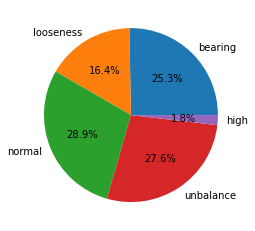

In [ ]:
bearing = train_1st_Bearing.shape[0]+train_2nd_Bearing.shape[0]
looseness = train_1st_Looseness.shape[0]+train_2nd_Looseness.shape[0]
normal = train_1st_Normal.shape[0] + train_3rd_Normal.shape[0]
unbalance = train_1st_Unbalance.shape[0] + train_2nd_Unbalance.shape[0] + train_3rd_Unbalance.shape[0]
high = train_1st_high.shape[0] 

plt.pie([bearing,looseness,normal,unbalance,high], labels=['bearing','looseness','normal','unbalance','high'], autopct='%.1f%%')
plt.show()

In [ ]:
Bearing1st_ds = Dataset_Constructor(train_1st_Bearing, label = 4 )
Looseness1st_ds = Dataset_Constructor(train_1st_Looseness,label = 2,window = 90)
Normal1st_ds = Dataset_Constructor(train_1st_Normal, label = 0 )
Unbalance1st_ds = Dataset_Constructor(train_1st_Unbalance, label = 1)
High1st_ds = Dataset_Constructor(train_1st_high, label = 3, window = 9)

100%|██████████| 487004/487004 [00:38<00:00, 12546.07it/s]


In [ ]:
Bearing2nd_ds = Dataset_Constructor(train_2nd_Bearing, label = 4 )
Looseness2nd_ds = Dataset_Constructor(train_2nd_Looseness,label = 2,window = 90)
Unbalance2nd_ds = Dataset_Constructor(train_2nd_Unbalance, label = 1)
Normal3rd_ds = Dataset_Constructor(train_3rd_Normal, label = 0)
Unbalance3rd_ds = Dataset_Constructor(train_3rd_Unbalance, label = 1)

100%|██████████| 184375/184375 [00:13<00:00, 13341.15it/s]


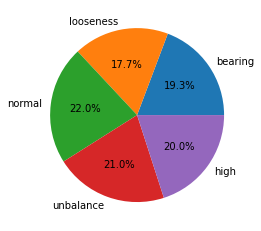

In [ ]:
bearing = Bearing1st_ds.__len__().numpy() + Bearing2nd_ds.__len__().numpy()
looseness = Looseness1st_ds.__len__().numpy() + Looseness2nd_ds.__len__().numpy()
normal = Normal1st_ds.__len__().numpy() + Normal3rd_ds.__len__().numpy()
unbalance = Unbalance1st_ds.__len__().numpy() + Unbalance2nd_ds.__len__().numpy() + Unbalance3rd_ds.__len__().numpy()
high = High1st_ds.__len__().numpy()

plt.pie([bearing,looseness,normal,unbalance,high], labels=['bearing','looseness','normal','unbalance','high'], autopct='%.1f%%')
plt.show()

In [ ]:
Dataset = Bearing1st_ds.concatenate(Looseness1st_ds).concatenate(Normal1st_ds).concatenate(Unbalance1st_ds).concatenate(High1st_ds).concatenate(Bearing2nd_ds).concatenate(Looseness2nd_ds).concatenate(Unbalance2nd_ds).concatenate(Normal3rd_ds).concatenate(Unbalance3rd_ds).shuffle(buffer_size = 4518720, seed = 42).batch(256).prefetch(1)

In [ ]:
Dataset.__len__().numpy()

9504

In [ ]:
Valid_Dataset = Dataset.take(1000) 
Train_Dataset = Dataset.skip(1000)

In [ ]:
Train_Dataset

<SkipDataset shapes: ((None, 128, 2), (None,)), types: (tf.float64, tf.float64)>

In [ ]:
Sample = list(Train_Dataset.unbatch().take(8500).as_numpy_iterator())[0][1]
Sample

3.0

In [ ]:
CM = keras.models.Sequential()
CM.add(tf.keras.layers.Flatten(input_shape=(128, 2)))
CM.add(keras.layers.Dense(units = 100, activation = 'relu'))
CM.add(keras.layers.Dense(units = 5, activation = 'softmax'))
CM.summary()
CM.compile(optimizer='adam',
           loss='sparse_categorical_crossentropy',
           metrics=['accuracy'])
CM.fit(Train_Dataset, epochs = 10, shuffle = True, validation_data = Valid_Dataset)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               25700     
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 505       
Total params: 26,205
Trainable params: 26,205
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
8504/8504 [==============================] - 35s 4ms/step - loss: 0.2680 - accuracy: 0.9026 - val_loss: 0.0737 - val_accuracy: 0.9761
Epoch 2/10
8504/8504 [==============================] - 33s 3ms/step - loss: 0.0582 - accuracy: 0.9809 - val_loss: 0.0492 - val_accuracy: 0.9841
Epoch 3/10
8504/8504 [==============================] - 33s 3ms/step - loss: 0.0386 - accu

In [ ]:
test_Dataset = test_Dataset.batch(batch_size=128)
test_Dataset

<BatchDataset shapes: ((None, 128, 2), (None,)), types: (tf.float64, tf.float64)>

In [ ]:
Sample = list(test_Dataset)[0]
Sample

(<tf.Tensor: shape=(128, 128, 2), dtype=float64, numpy=
 array([[[ 6.62576243e-03, -1.00764169e+00],
         [ 3.39681656e-01, -1.19356350e+00],
         [ 1.55026444e-01, -3.02771980e-01],
         ...,
         [ 3.81732738e-01, -5.45504279e+00],
         [ 4.37805814e-01, -2.76629185e+00],
         [-1.68015868e-01,  1.26913680e+00]],
 
        [[-3.73458201e-01, -8.20410529e-02],
         [ 7.62308440e-01,  2.20492984e+00],
         [ 3.10487685e-02, -1.49788995e+00],
         ...,
         [ 4.75520658e-01, -1.09894112e+00],
         [-1.09677815e-01, -1.28995913e+00],
         [-3.45503620e-01, -1.01553931e+00]],
 
        [[ 4.07943884e-01,  2.46200470e+00],
         [-2.60822903e-02,  1.37903288e+00],
         [-7.95774654e-02, -3.63792047e+00],
         ...,
         [-1.09707617e-01,  1.57315033e+00],
         [ 2.42091347e-02, -2.63836536e+00],
         [-3.29618980e-01, -2.20459251e+00]],
 
        ...,
 
        [[ 8.30687285e-02, -4.05561497e+00],
         [-4.40828952e-

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9432541290>]],
      dtype=object)

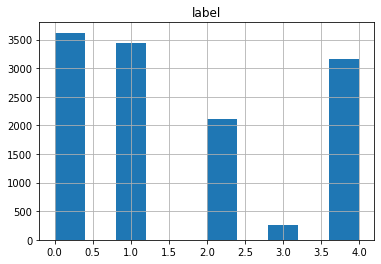

In [ ]:
pred = CM.predict(test_Dataset)
a = np.argmax(pred,axis = 1)
sub.iloc[:,1] = a
sub.to_csv('/content/gdrive/MyDrive/CM.csv', index = False)
sub.hist()